<a href="https://colab.research.google.com/github/JoeL-8883/Fencing-Score-Predictor/blob/main/predict_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from bs4 import BeautifulSoup
import requests
import os
import gdown
import kagglehub

In [2]:
path = kagglehub.dataset_download("foillee/fencing-points")
csv_path = os.path.join(path, 'data.csv')
df = pd.read_csv(csv_path)
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date'])
df.head()


100%|██████████| 332k/332k [00:00<00:00, 74.2MB/s]

Extracting files...


,fie_ID,fencer_name,age,dob,nationality,rank,host_city,event_type,points_earned,date
5279,17148,ROWLES Thomas,17,1990-05-30,GBR,504,Londres,Satellite,0.0,2007-10-21
4878,14529,REMIJN Martin,18,1989-07-25,NED,251,Londres,Satellite,0.0,2007-10-21
4873,16321,STIJLAART Mats,17,1990-10-08,NED,250,Londres,Satellite,0.0,2007-10-21
4864,17823,AVOLA Giorgio,18,1989-05-08,ITA,247,Londres,Satellite,2.0,2007-10-21
4858,3247,KENBER Jamie,20,1986-11-14,GBR,245,Londres,Satellite,3.0,2007-10-21


In [3]:
'''Remove satellite events - these give very few points so even winning a satellite implies that a fencer performed poorly'''
'''We can assume that top fencers do not attend these events - they are the subject of this project for now'''
'''At some point I will have to devise a better metric than points'''
df = df[df['event_type'] != 'Satellite']

'''Delete data for fencers who do not compete regularly'''
# NOTE - the threshold must be equal to sequence_length / train_split
threshold = 20 # the number of non-satellite events each fencer must have attended to be considered
fencer_counts = df['fencer_name'].value_counts()
fencers_to_delete = fencer_counts[fencer_counts < 20].index
print(f'Deleting {len(fencers_to_delete)} fencers')
df = df[~df['fencer_name'].isin(fencers_to_delete)]

Deleting 1735 fencers


Different levels of competitions multiply points by different factors, for instance, in the Olympics you can see the spike in points in Cheung Ka Long's two Olympic golds. So we use and predict rolling averages

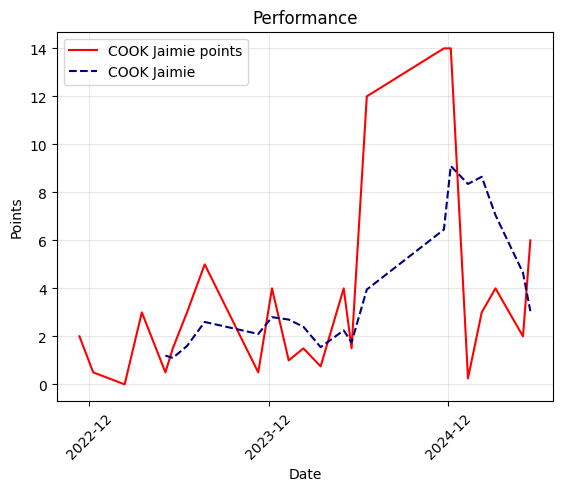

In [81]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fencer_name = 'COOK Jaimie'
df_fencer = df[df['fencer_name'] == fencer_name]
plt.title('Performance')
plt.xlabel('Date')
plt.ylabel('Points')

# Compute rolling averages
window = 5
rolling_avg = df_fencer['points_earned'].rolling(window=window).mean()
plt.plot(df_fencer['date'], df_fencer['points_earned'], label=fencer_name + ' points', color='red')
plt.plot(df_fencer['date'], rolling_avg, label=fencer_name, color='navy', linestyle='--')


plt.grid(True, alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()


In [5]:
window_size = 8
# Compute rolling averages
df['rolling_avg_points'] = df.groupby('fencer_name')['points_earned'].transform(lambda x: x.rolling(window=window_size).mean())

# Fill NaN values
df['rolling_avg_points'] = df['rolling_avg_points'].fillna(method='bfill') # Fill initial NaNs with the first valid value
df['rolling_avg_points'] = df['rolling_avg_points'].fillna(0) # Fill any remaining NaNs with 0 if necessary


<ipython-input-5-4db95eb1c587>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rolling_avg_points'] = df['rolling_avg_points'].fillna(method='bfill') # Fill initial NaNs with the first valid value


In [6]:
points_mean = df['points_earned'].mean()
points_std = df['points_earned'].std()
df['points_normalised'] = (df['points_earned'] - points_mean) / points_std

rolling_mean = df['rolling_avg_points'].mean()
rolling_std = df['rolling_avg_points'].std()
df['rolling_avg_points_normalised'] = (df['rolling_avg_points'] - rolling_mean) / rolling_std

### Predictive Model

Dataset

Points alone is not good enough data in predicting a fencer's performance in the future, we need to include features such as their rank at the time, their age, etc.

In [7]:
'''One-hot encoding of fencer's nationality'''
one_hot_nationality = pd.get_dummies(df['nationality'], prefix='nationality')
df = pd.concat([df, one_hot_nationality], axis=1)

~~Number of competitions -- we would expect that fencers peak after a number of competitions, however their performance will also degrade as they get older and their physique wears down.~~

We can't use this as this counts instances of competitions, not the nth competition a fencer actually competed in!

In [8]:
#df['competition_count'] = df.groupby('fencer_name').cumcount() + 1

In [9]:
class FencerSequenceDataset(Dataset):
  def __init__(self, df, sequence_length=11):
    self.sequences = []
    self.targets = []
    self.sequence_length = sequence_length

    for fencer_name, fencer_df in df.items():
      # Concatenate features with one-hot encoding of nationalities
      ranking_data = fencer_df[['points_normalised', 'rolling_avg_points_normalised', 'rank', 'age']].values
      nationality_columns = [col for col in fencer_df.columns if col.startswith('nationality_')]
      features = np.concatenate((ranking_data, fencer_df[nationality_columns].values), axis=1)

      # Create sliding windows
      for i in range(len(features) - sequence_length):
        point = features[i:i+sequence_length]
        target = features[i+sequence_length, 1] # only predict rolling_avg_points_normalised

        self.sequences.append(torch.tensor(point, dtype=torch.float32)) # convert to tensors so they can be stacked
        self.targets.append(torch.tensor(target, dtype=torch.float32))

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, idx):
    return self.sequences[idx], self.targets[idx]


In [10]:
''' Split the data for each fencer'''
data_size = len(df)
train_split = 0.6
val_split = 0.2
test_split = 0.2

fencer_train_data = {}
fencer_val_data = {}
fencer_test_data = {}

fencers_grouped = df.groupby('fencer_name') # We can naively assume that each fencer has a different name

for fencer_name, fencer_df in fencers_grouped:
  fencer_df = fencer_df.sort_values(by='date')

  total_size = len(fencer_df)
  train_size = int(total_size * train_split)
  val_size = int(total_size * val_split)
  test_size = total_size - train_size - val_size

  # Split Data
  fencer_train_data[fencer_name] = fencer_df[:train_size]
  fencer_val_data[fencer_name] = fencer_df[train_size:train_size + val_size]
  fencer_test_data[fencer_name] = fencer_df[train_size + val_size:]

In [11]:
training_data = FencerSequenceDataset(fencer_train_data)
val_data = FencerSequenceDataset(fencer_val_data)
test_data = FencerSequenceDataset(fencer_test_data)

batch_size=32
train_dataloader = DataLoader(training_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Setup model

In [12]:
'''Start with a basic RNN'''
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.25):
      super(RNN, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.dropout = nn.Dropout(dropout)

      self.W_ih = nn.Linear(input_size, hidden_size, bias=True) # input to hidden
      self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True) # hidden weights
      self.W_ho = nn.Linear(hidden_size, output_size, bias=True) # hidden to output

    def forward(self, input, h_0=None):
      if h_0 is None:
        h_0 = torch.zeros(self.hidden_size, device=device)

      input = self.dropout(input)
      h_t = torch.tanh(self.W_ih(input) + self.W_hh(h_0))
      h_t = self.dropout(h_t)
      ouput = self.W_ho(h_t)

      return ouput, h_t

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
'''Valdiation'''
def evaluate_model(model, dataloader):
  model.eval()
  total_val_loss = 0

  with torch.no_grad():
    for sequences, targets in val_dataloader:
      sequences = sequences.to(device)
      targets = targets.to(device)
      batch_loss = 0

      for i in range(sequences.size(0)):
        sequence = sequences[i]
        target = targets[i]

        hidden_state = torch.zeros(model.hidden_size, device=device)
        output = None

        for t in range(sequence.size(0)):
          output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

          # Calculate loss for each prediction in the sequence
          loss = criterion(output, target.unsqueeze(0))
          batch_loss += loss

      average_batch_loss = batch_loss / sequences.size(0)
      total_val_loss += average_batch_loss.item()

  average_val_loss = total_val_loss / len(val_dataloader)
  print(f'Average Validation Loss: {average_val_loss:.4f}')
  return average_val_loss

In [15]:
input_size = 4 # number of features
nationality_count = len([col for col in df.columns if col.startswith('nationality_')])
input_size += nationality_count

hidden_size = 100 # A larger hidden_size causes the model to overfit
output_size = 1 # i.e. predicting points earned from a competition

dropout = 0.3
best_val_loss = float('inf')
patience = 5
counter = 0
best_model = None


model = RNN(input_size, hidden_size, output_size, dropout)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

epochs = 20 # model seems to converge after 10 epochs

for epoch in range(epochs):
  total_train_loss = 0
  num_batches = 0

  model.train()

  for sequences, targets in train_dataloader: # iterate through each batch
    optimizer.zero_grad()
    batch_loss = 0

    sequences = sequences.to(device) # shape: (batch_size, sequence_length, input_size)
    targets = targets.to(device) # shape: batch_size

    # Iterate through each sequence in the batch
    for i in range(sequences.size(0)):
      sequence = sequences[i]
      target = targets[i]

      hidden_state = torch.zeros(model.hidden_size, device=device) # reset the hidden state for each sequence
      output = None

      # Compute loss for a single sequence
      for t in range(sequence.size(0)):
        output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

        loss = criterion(output, target.unsqueeze(0)) # loss for a single sequence
        batch_loss += loss # losses for all sequences in a batch

    # Compute losses after each sequence
    average_batch_loss = batch_loss / sequences.size(0)
    average_batch_loss.backward()
    optimizer.step()

    total_train_loss += average_batch_loss.item()

  average_train_loss = total_train_loss / len(train_dataloader)
  print(f'Epoch [{epoch+1}/{epochs}], Average Training Loss: {average_train_loss:.4f}')

  # Validation loss
  val_loss = evaluate_model(model, val_dataloader)

  if val_loss < best_val_loss:
    counter = 0
    best_val_loss = val_loss
    best_model = model.state_dict()
  else:
    counter += 1
    if counter >= patience:
      print(f'Early stopping at epoch {epoch+1}')
      break

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Average Training Loss: 10.6659
Average Validation Loss: 5.1832
Epoch [2/20], Average Training Loss: 8.4160
Average Validation Loss: 4.3599
Epoch [3/20], Average Training Loss: 7.0770
Average Validation Loss: 3.9172
Epoch [4/20], Average Training Loss: 6.1678
Average Validation Loss: 3.8443
Epoch [5/20], Average Training Loss: 5.6634
Average Validation Loss: 3.8354
Epoch [6/20], Average Training Loss: 5.3851
Average Validation Loss: 3.6880
Epoch [7/20], Average Training Loss: 5.2052
Average Validation Loss: 3.6247
Epoch [8/20], Average Training Loss: 4.9593
Average Validation Loss: 3.7180
Epoch [9/20], Average Training Loss: 4.8919
Average Validation Loss: 3.5892
Epoch [10/20], Average Training Loss: 4.7449
Average Validation Loss: 3.6205
Epoch [11/20], Average Training Loss: 4.6775
Average Validation Loss: 3.5482
Epoch [12/20], Average Training Loss: 4.6358
Average Validation Loss: 3.6925
Epoch [13/20], Average Training Loss: 4.5549
Average Validation Loss: 3.4719
Epoch [

In [16]:
torch.save(best_model, 'model.pth')
model_path = '/content/model.pth'
print(f"Model saved to {model_path}")

In [24]:
'''Testing'''
model.eval()
total_test_loss = 0
num_batches = 0

with torch.no_grad():
  for sequences, targets in test_dataloader:
    sequences = sequences.to(device)
    targets = targets.to(device)
    batch_loss = 0
    for i in range(sequences.size(0)):
      hidden_state = torch.zeros(model.hidden_size, device=device)
      sequence = sequences[i]
      target = targets[i]
      output = None

      for t in range(len(sequence)):
        output, hidden_state = model(sequence[t].unsqueeze(0), hidden_state)

        loss = criterion(output, target.unsqueeze(0))
        batch_loss += loss.item()

    average_batch_loss = batch_loss / sequences.size(0)
    total_test_loss += average_batch_loss

average_test_loss = total_test_loss / len(test_dataloader)
print(f'Average Test Loss: {average_test_loss:.4f}')

Average Test Loss: 3.8862


In [85]:
def get_best_fencer(df):
  # Assuming that the df is sorted by date, then get the last entry of each fencer
  last_entries = df.groupby('fencer_name').tail(1)
  best_fencer = last_entries.loc[last_entries['current_rank'].idxmin()]
  best_fencer_name = best_fencer['fencer_name']
  return best_fencer

# Get the next competition date based on the date of the next event from the season before
# Fencing competitions are held within days of each other in previous seasons so this assumption is valid
def get_next_comp_date(last_comp_date):
  prev_year = last_comp_date - pd.Timedelta(days=365)
  prev_comp_dates = fencer_df[(fencer_df['date'] >= prev_year) & (fencer_df['date'] < last_comp_date)]

  if prev_comp_dates.empty:
    raise Exception(f'No previous competitions found, exception has not yet been implemented.')

    '''
    # Choose a fencer who has been competing regularly and use their next comp date
    # We just use the current world no. 1
    # !!! There is a better way to implement this, but this should be fine for now.
    best_fencer_name = get_best_fencer(fencer_df)
    best_fencer_df = df[df['fencer_name'] == best_fencer_name].sort_values(by='date')
    best_last_comp_date = best_fencer_df.iloc[-1]['date']
    return get_next_comp_date(best_fencer_df, best_last_comp_date) + pd.Timedelta(days=365)
    '''
  else:
    # Get the second entry as the first entry is just the last competiton the fencer competed at
    pred_date = prev_comp_dates.iloc[1]['date'] + pd.Timedelta(days=365)
    return pred_date


ISSUES:
* We need a way to also predict the fencers rank in the future, as the fencers same rank cannot be used for predictions as well as training




In [88]:
def fencer_forecast_full_history(model, fencer_df, num_predictions):
  '''
  Perform autoregressive forecasting for a given fencer

  Args:
    model: trained RNN
    fencer_df: dataframe containing all competition data for a particular fencer
    num_predictions: number of future predictions ot predict

  Returns:
    A DataFrame of future predicted rolling averages
  '''

  model.eval()
  fencer_copy_df = fencer_df.copy().sort_values(by='date')

  features = ['points_normalised', 'rolling_avg_points_normalised', 'age', 'rank']
  nationality_cols = [col for col in fencer_df.columns if col.startswith('nationality_')]
  all_features = features + nationality_cols

  debug_history = fencer_copy_df[features]
  history = fencer_copy_df[all_features].values.astype(np.float32)
  history_tensor = torch.tensor(history, dtype=torch.float32, device=device)

  # Initialise prediction df
  new_comp_df_headers = ['fencer_name', 'age', 'points', 'date']
  pred_df = pd.DataFrame(columns=new_comp_df_headers)
  pred_df = pd.concat([pred_df, fencer_copy_df[['fencer_name', 'age', 'points_earned', 'date']].iloc[-1]])

  # Process entire history
  with torch.no_grad():
    hidden_state = None
    output = None
    for t in range(history_tensor.size(0)):
      output, hidden_state = model(history_tensor[t].unsqueeze(0), hidden_state)

  '''
  Autoregressive prediction
    also compose prediction df using predicted values and fencer features
  '''
  nationality_features = fencer_df.iloc[-1][nationality_cols].values.tolist()
  rank = fencer_df.iloc[-1]['rank']

  # Unsqueeze creates a new dimension to create mini-batch of size 1
  last_step = history_tensor[-1, :].unsqueeze(0)

  for i in range(num_predictions):
    with torch.no_grad():
      output, hidden_state = model(last_step, hidden_state)
      predicted_rolling_avg_normalised = output.item()

      # We must assume that points is similar to the rolling average (as its difficult to compute the points earned)
      # !!! Could we determine what type of event would be next then determine multipliers from there?
      predicted_points_normalised = predicted_rolling_avg_normalised

      # Predict the date of the next competition
      last_comp_date = pred_df.iloc[-1]['date']
      next_comp_date_pred = get_next_comp_date(last_comp_date)
      dob = fencer_df.iloc[-1]['dob']
      next_age = int((next_comp_date_pred - pd.to_datetime(dob)).days / 365.25)

      new_features = [
          predicted_points_normalised,
          predicted_rolling_avg_normalised,
          next_age,
          rank
      ]
      new_features.extend(nationality_features)

      new_features_array = np.array(new_features, dtype=np.float32)
      last_step = torch.tensor(new_features_array, device=device) # New features becomes the input for the next iteration

      # Add prediction to df
      predicted_rolling_avg = predicted_rolling_avg_normalised * rolling_std + rolling_mean

      new_row = {col: None for col in new_comp_df_headers}
      new_row.update({
          'fencer_name': fencer_df.iloc[-1]['fencer_name'],
          'age': next_age,
          'points': predicted_rolling_avg,
          'date': pd.to_datetime(next_comp_date_pred)
      })
      pred_df = pd.concat([pred_df, pd.DataFrame([new_row])], ignore_index=True)

  return pred_df.sort_values(by='date')

In [89]:
model_save_path = '/content/model.pth'
model = RNN(input_size, hidden_size, output_size)
model = model.to(device)
model.load_state_dict(torch.load(model_save_path))

fencer_name = 'CHEUNG Ka Long'
num_predictions = 20

fencer_df = df[df['fencer_name'] == fencer_name]

predictions = fencer_forecast_full_history(model, fencer_df, num_predictions)
print(predictions)

TypeError: Invalid comparison between dtype=datetime64[ns] and float

In [ ]:
'''
model_save_path = '/content/model.pth'
model = RNN(input_size, hidden_size, output_size)
model = model.to(device)
model.load_state_dict(torch.load(model_save_path))
model.eval()

def fencer_forecast(model, initial_sequence_df, num_predictions, sequence_length):
  predicted_rolling_avg_list = []
  current_sequence_df = initial_sequence_df.copy()
  nationality_cols = [col for col in initial_sequence_df.columns if col.startswith('nationality_')]
  last_nationality_features = current_sequence_df[nationality_cols].iloc[-1].values.tolist() #iloc gets the last row
  current_rank = current_sequence_df['rank'].iloc[-1]
  current_age = current_sequence_df['age'].iloc[-1]
  dob = current_sequence_df['dob'].iloc[-1]

  counter = 0 # number of times a prediction is made

  # Get data for a prediction
  for i in range(num_predictions):
    ranking_data = current_sequence_df[['points_normalised', 'rolling_avg_points_normalised', 'rank', 'age']].values
    features = np.concatenate((ranking_data, current_sequence_df[nationality_cols]), axis=1)
    features_tensor = torch.tensor(features, dtype=torch.float32, device=device)

    # Make predictions
    with torch.no_grad():
      hidden_state = None
      output = None
      for t in range(sequence_length):
        output, hidden_state = model(features_tensor[t+counter].unsqueeze(0), hidden_state)
      counter += 1

      predicted_rolling_avg_normalised = output.item()
      predicted_rolling_avg = predicted_rolling_avg_normalised * rolling_std + rolling_mean
      predicted_rolling_avg_list.append(predicted_rolling_avg)

    next_prediction_df = pd.DataFrame({
        'points_earned': predicted_rolling_avg,
        'rolling_avg_points': predicted_rolling_avg,
        'points_normalised': predicted_rolling_avg_normalised,
        'rolling_avg_points_normalised': predicted_rolling_avg_normalised,
        'rank': current_rank,
        'date': get_next_comp_date(current_sequence_df, current_sequence_df.iloc[-1]['date']),
        'age': current_age # Compute the fencers age at the date of the competition
        # df['age'] = ( (df['date'] - df['dob']).dt.days // 365.25).astype(int)
    }, index=[0])

    # Add nationalities
    for col, val in zip(nationality_cols, last_nationality_features):
      next_prediction_df[col] = val

    # Create dataframe row for predicted event
    predicted_event_df = pd.DataFrame(next_prediction_df)
    current_sequence_df = pd.concat([current_sequence_df, predicted_event_df], ignore_index=True)

  return predicted_rolling_avg_list



'''